GDCV_1 : 없다면 어떻게 될까? (ResNet Ablation Study)

<<목차>>

0) 라이브러리 버전 확인하기

1) ResNet 기본 블록 구성하기

2) ResNet-34, ResNet-50 Complete Model

3) 일반 네트워크(plain network) 만들기

4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

5) 루브릭

6) 회고

0) 라이브러리 버전 확인하기

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()


print(tf.__version__)
print(pd.__version__)
print(np.__version__)

2022-11-30 11:08:49.486090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 11:08:49.769184: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-30 11:08:50.673237: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.0/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.7/lib64
2022-11-30 11:08:50.673298: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

2.10.0
1.4.2
1.22.4


In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

2022-11-30 11:08:55.689019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 11:08:55.733983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 11:08:55.734147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
BATCH_SIZE = 32  # 256
EPOCHS = 10  # 15
LR = 0.1
OPT_DECAY = 0.0001
MOMENTUM = 0.9
L2_WEIGHT_DECAY = 1e-4
BATCH_NORM_DECAY = 0.9
BATCH_NORM_EPSILON = 1e-5

ACTIVATION = 'sigmoid'
NUM_CLASSES = 1

In [4]:
# tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

2022-11-30 11:08:59.920833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 11:08:59.921699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 11:08:59.921866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 11:08:59.921957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [5]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [6]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(18610, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(4652, shape=(), dtype=int64)

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [7]:
ds_info.features["label"].num_classes  # 2

2

In [8]:
ds_info.features["label"].names  # ['cat', 'dog']

['cat', 'dog']

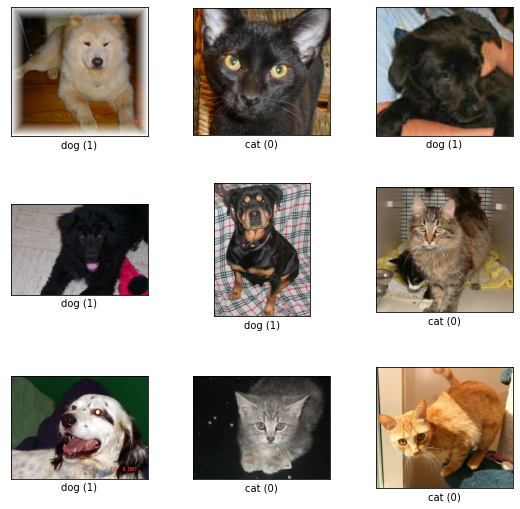

In [9]:
fig = tfds.show_examples(ds_train, ds_info)

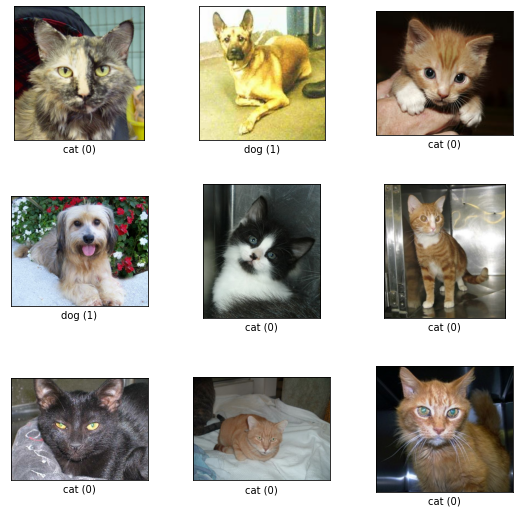

In [10]:
fig = tfds.show_examples(ds_test, ds_info)

In [11]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [12]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [13]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [14]:
for input in ds_train.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(32, 224, 224, 3)
(32,)


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1) ResNet 기본 블록 구성하기

In [15]:
def conv_block(input_layer, 
                channel, 
                kernel_size, 
                strides=1, 
                activation='relu',
                l2_weight_decay=1e-4,
                batch_norm_decay=0.9,
                batch_norm_epsilon=1e-5):
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=kernel_size,
        kernel_initializer='he_normal',
        kernel_regularizer=keras.regularizers.l2(l2_weight_decay),
        padding='same',
        strides=strides,
        use_bias=False,
    )(input_layer)
    
    x = keras.layers.BatchNormalization(
        # momentum=batch_norm_decay,
        # epsilon=batch_norm_epsilon,
    )(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [16]:
def build_net_block(input_layer, 
                    cnn_count=3, 
                    channel=64, 
                    block_num=0, 
                    is_50=True,
                    is_ResNet=True):

    x = input_layer
    
    # 첫 번째 conv_layer 에서 strides=2 설정해서 너비와 높이를 줄임
    # => 필터의 개수(=채널)가 증가할 때마다 너비와 높이를 줄임

    # ResNet-50, Plain-50
    if is_50:
        if is_ResNet: # ResNet-50
            for i in range(cnn_count):
                if i == 0:
                    shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-50
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
                else:
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
    # ResNet-34, Plain-34
    else:
        if is_ResNet:  # ResNet-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3))
                else:
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3))

    return x

In [17]:
def build_net(input_shape=(32,32,3),
                cnn_count_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=10, 
                is_50=True,
                is_ResNet=True,
                activation='softmax',
                name='ResNet_50'):
    
    # 모델 생성 전, config list들이 같은 길이인지 확인
    assert len(cnn_count_list) == len(channel_list)
    
    # input layer 생성
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer 설정
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서
    # - is_ResNet=True 일 경우, Residual block 블록을 생성합니다.
    # - is_ResNet=False 일 경우, Plain block 블록을 생성합니다.
    for block_num, (cnn_count, channel) in enumerate(zip(cnn_count_list, channel_list)):
        x = build_net_block(x, 
                            cnn_count=cnn_count, 
                            channel=channel, 
                            block_num=block_num, 
                            is_50=is_50,
                            is_ResNet=is_ResNet)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                        activation=activation, 
                        kernel_initializer='he_normal'
                        )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

2) ResNet-34, ResNet-50 Complete Model

In [18]:
resnet_34 = build_net(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=True,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='ResNet_34',
)
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

In [19]:
resnet_50 = build_net(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=True,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='ResNet_50',
)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 64  9408        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 112, 112, 64  256        ['conv2d_36[0][0]']              
 ormalization)                  )                                                         

3) 일반 네트워크(plain network) 만들기

In [20]:
plain_34 = build_net(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=False,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='Plain_34',
)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_89 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        368

In [21]:
plain_50 = build_net(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=False,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='Plain_50',
)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_122 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_123 (Conv2D)         (None, 56, 56, 64)        409

4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

In [22]:
def comile_and_fit(model, ds_train, ds_test, ds_info, learning_rate=0.001, momentum= 0.9, opt_decay=0.0001, batch_size=128, epochs=15):
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=learning_rate,
            momentum=momentum,
            decay=opt_decay,
            clipnorm=1.
        ),
        metrics=['accuracy'],
    )

    history = model.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['train[80%:]'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history

In [23]:
history_resnet_34 = comile_and_fit(resnet_34, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
2022-11-30 11:18:34.484812: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-11-30 11:18:35.507447: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 28/581 [>.............................] - ETA: 1:14 - loss: 2.8776 - accuracy: 0.5145

 40/581 [=>............................] - ETA: 1:12 - loss: 2.7908 - accuracy: 0.5188

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 1:02 - loss: 2.6518 - accuracy: 0.5257

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 35s - loss: 2.4646 - accuracy: 0.5277

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 33s - loss: 2.4557 - accuracy: 0.5285

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 32s - loss: 2.4532 - accuracy: 0.5287

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


364/581 [=================>............] - ETA: 29s - loss: 2.4367 - accuracy: 0.5301

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 28s - loss: 2.4314 - accuracy: 0.5298

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 2.3326 - accuracy: 0.5419

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3318 - accuracy: 0.5421

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 104s 156ms/step - loss: 2.3318 - accuracy: 0.5421 - val_loss: 2.0934 - val_accuracy: 0.5556
Epoch 2/10
 30/581 [>.............................] - ETA: 1:14 - loss: 2.0771 - accuracy: 0.6021

 41/581 [=>............................] - ETA: 1:12 - loss: 2.0760 - accuracy: 0.5976

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 1:05 - loss: 2.0560 - accuracy: 0.5886

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


317/581 [===============>..............] - ETA: 36s - loss: 2.0011 - accuracy: 0.5940

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 33s - loss: 1.9958 - accuracy: 0.5945

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 32s - loss: 1.9926 - accuracy: 0.5931

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 28s - loss: 1.9852 - accuracy: 0.5945

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 27s - loss: 1.9833 - accuracy: 0.5953

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 1.9341 - accuracy: 0.6007

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.9338 - accuracy: 0.6008

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 89s 153ms/step - loss: 1.9338 - accuracy: 0.6008 - val_loss: 1.8088 - val_accuracy: 0.5802
Epoch 3/10
 22/581 [>.............................] - ETA: 1:15 - loss: 1.7844 - accuracy: 0.6179

 42/581 [=>............................] - ETA: 1:12 - loss: 1.7788 - accuracy: 0.6310

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:02 - loss: 1.7605 - accuracy: 0.6339

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 35s - loss: 1.7213 - accuracy: 0.6336

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 33s - loss: 1.7176 - accuracy: 0.6333

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 31s - loss: 1.7132 - accuracy: 0.6361

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 28s - loss: 1.7076 - accuracy: 0.6355

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 27s - loss: 1.7068 - accuracy: 0.6346

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.6636 - accuracy: 0.6456

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 89s 153ms/step - loss: 1.6636 - accuracy: 0.6456 - val_loss: 1.7814 - val_accuracy: 0.5656
Epoch 4/10
 32/581 [>.............................] - ETA: 1:14 - loss: 1.5196 - accuracy: 0.6934

 43/581 [=>............................] - ETA: 1:12 - loss: 1.5190 - accuracy: 0.6853

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:03 - loss: 1.5107 - accuracy: 0.6823

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 35s - loss: 1.4815 - accuracy: 0.6890

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 33s - loss: 1.4788 - accuracy: 0.6906

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 31s - loss: 1.4772 - accuracy: 0.6915

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 28s - loss: 1.4725 - accuracy: 0.6937

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 27s - loss: 1.4721 - accuracy: 0.6933

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.4370 - accuracy: 0.6987

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 89s 153ms/step - loss: 1.4370 - accuracy: 0.6987 - val_loss: 1.3941 - val_accuracy: 0.6602
Epoch 5/10
  2/581 [..............................] - ETA: 1:18 - loss: 1.3519 - accuracy: 0.6719

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 23/581 [>.............................] - ETA: 1:16 - loss: 1.3375 - accuracy: 0.7147

 42/581 [=>............................] - ETA: 1:13 - loss: 1.3417 - accuracy: 0.7091

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:03 - loss: 1.3326 - accuracy: 0.7136

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 34s - loss: 1.2911 - accuracy: 0.7277

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 33s - loss: 1.2877 - accuracy: 0.7300

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 31s - loss: 1.2839 - accuracy: 0.7319

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 27s - loss: 1.2781 - accuracy: 0.7338

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 27s - loss: 1.2770 - accuracy: 0.7339

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.2509 - accuracy: 0.7397

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 89s 153ms/step - loss: 1.2509 - accuracy: 0.7397 - val_loss: 1.2257 - val_accuracy: 0.7052
Epoch 6/10
  3/581 [..............................] - ETA: 1:18 - loss: 1.0704 - accuracy: 0.8750

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 26/581 [>.............................] - ETA: 1:15 - loss: 1.1535 - accuracy: 0.7825

 43/581 [=>............................] - ETA: 1:12 - loss: 1.1670 - accuracy: 0.7645

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:02 - loss: 1.1595 - accuracy: 0.7578

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 34s - loss: 1.1322 - accuracy: 0.7606

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 33s - loss: 1.1325 - accuracy: 0.7599

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 31s - loss: 1.1293 - accuracy: 0.7615

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 27s - loss: 1.1265 - accuracy: 0.7621

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 27s - loss: 1.1255 - accuracy: 0.7624

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.1041 - accuracy: 0.7671

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 89s 154ms/step - loss: 1.1041 - accuracy: 0.7671 - val_loss: 1.1755 - val_accuracy: 0.7110
Epoch 7/10
  1/581 [..............................] - ETA: 1:18 - loss: 0.9551 - accuracy: 0.8438

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 1:14 - loss: 1.0162 - accuracy: 0.7930

 46/581 [=>............................] - ETA: 1:12 - loss: 1.0265 - accuracy: 0.7867

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:02 - loss: 1.0263 - accuracy: 0.7858

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 34s - loss: 1.0071 - accuracy: 0.7866

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 32s - loss: 1.0069 - accuracy: 0.7860

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 31s - loss: 1.0058 - accuracy: 0.7862

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 27s - loss: 1.0021 - accuracy: 0.7871

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 26s - loss: 1.0023 - accuracy: 0.7864

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9776 - accuracy: 0.7913

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 89s 153ms/step - loss: 0.9776 - accuracy: 0.7913 - val_loss: 1.5433 - val_accuracy: 0.5976
Epoch 8/10
  3/581 [..............................] - ETA: 1:18 - loss: 1.0078 - accuracy: 0.6979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 1:15 - loss: 0.9301 - accuracy: 0.8067

 47/581 [=>............................] - ETA: 1:12 - loss: 0.9075 - accuracy: 0.8178

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:02 - loss: 0.8953 - accuracy: 0.8191

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 34s - loss: 0.8703 - accuracy: 0.8258

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 32s - loss: 0.8699 - accuracy: 0.8255

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 31s - loss: 0.8689 - accuracy: 0.8251

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 27s - loss: 0.8647 - accuracy: 0.8271

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 26s - loss: 0.8639 - accuracy: 0.8273

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8476 - accuracy: 0.8291

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 89s 153ms/step - loss: 0.8476 - accuracy: 0.8291 - val_loss: 1.2823 - val_accuracy: 0.6690
Epoch 9/10
  6/581 [..............................] - ETA: 1:17 - loss: 0.7867 - accuracy: 0.8438

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 1:14 - loss: 0.7428 - accuracy: 0.8768

 47/581 [=>............................] - ETA: 1:12 - loss: 0.7549 - accuracy: 0.8624

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:02 - loss: 0.7713 - accuracy: 0.8507

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 34s - loss: 0.7452 - accuracy: 0.8613

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 32s - loss: 0.7447 - accuracy: 0.8611

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 31s - loss: 0.7432 - accuracy: 0.8611

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 27s - loss: 0.7399 - accuracy: 0.8620

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 26s - loss: 0.7395 - accuracy: 0.8616

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7280 - accuracy: 0.8635

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 89s 152ms/step - loss: 0.7280 - accuracy: 0.8635 - val_loss: 0.7931 - val_accuracy: 0.8229
Epoch 10/10
  6/581 [..............................] - ETA: 1:18 - loss: 0.6345 - accuracy: 0.9010

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 1:15 - loss: 0.7003 - accuracy: 0.8715

 48/581 [=>............................] - ETA: 1:12 - loss: 0.6881 - accuracy: 0.8802

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:02 - loss: 0.6766 - accuracy: 0.8802

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 34s - loss: 0.6596 - accuracy: 0.8832

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 32s - loss: 0.6600 - accuracy: 0.8833

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 31s - loss: 0.6617 - accuracy: 0.8826

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 27s - loss: 0.6589 - accuracy: 0.8834

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 26s - loss: 0.6593 - accuracy: 0.8830

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.8883

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 89s 154ms/step - loss: 0.6402 - accuracy: 0.8883 - val_loss: 1.1487 - val_accuracy: 0.7017


In [24]:
history_plain_34 = comile_and_fit(plain_34, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 1:11 - loss: 2.3566 - accuracy: 0.5185

 40/581 [=>............................] - ETA: 1:09 - loss: 2.3664 - accuracy: 0.5188

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


110/581 [====>.........................] - ETA: 1:00 - loss: 2.3045 - accuracy: 0.5011

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 33s - loss: 2.2087 - accuracy: 0.5200

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 31s - loss: 2.2036 - accuracy: 0.5198

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 30s - loss: 2.2000 - accuracy: 0.5216

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 27s - loss: 2.1881 - accuracy: 0.5278

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 26s - loss: 2.1857 - accuracy: 0.5288

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


577/581 [============================>.] - ETA: 0s - loss: 2.1210 - accuracy: 0.5417

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.1199 - accuracy: 0.5420

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 97s 147ms/step - loss: 2.1199 - accuracy: 0.5420 - val_loss: 1.9824 - val_accuracy: 0.5162
Epoch 2/10
 28/581 [>.............................] - ETA: 1:11 - loss: 1.9354 - accuracy: 0.5960

 40/581 [=>............................] - ETA: 1:09 - loss: 1.9314 - accuracy: 0.5961

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 1:00 - loss: 1.9119 - accuracy: 0.5924

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 33s - loss: 1.8650 - accuracy: 0.5994

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 31s - loss: 1.8618 - accuracy: 0.6000

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 30s - loss: 1.8594 - accuracy: 0.5998

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 26s - loss: 1.8541 - accuracy: 0.5988

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 26s - loss: 1.8531 - accuracy: 0.5981

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 1.8102 - accuracy: 0.5957

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.8101 - accuracy: 0.5955

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 85s 146ms/step - loss: 1.8101 - accuracy: 0.5955 - val_loss: 1.6939 - val_accuracy: 0.5872
Epoch 3/10
 29/581 [>.............................] - ETA: 1:11 - loss: 1.6784 - accuracy: 0.6013

 40/581 [=>............................] - ETA: 1:09 - loss: 1.6766 - accuracy: 0.6016

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 1:00 - loss: 1.6635 - accuracy: 0.6007

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 33s - loss: 1.6246 - accuracy: 0.6135

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 31s - loss: 1.6236 - accuracy: 0.6110

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 30s - loss: 1.6219 - accuracy: 0.6096

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 26s - loss: 1.6170 - accuracy: 0.6108

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 25s - loss: 1.6162 - accuracy: 0.6109

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


576/581 [============================>.] - ETA: 0s - loss: 1.5862 - accuracy: 0.6094

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.5857 - accuracy: 0.6091

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 85s 146ms/step - loss: 1.5857 - accuracy: 0.6091 - val_loss: 1.4978 - val_accuracy: 0.5981
Epoch 4/10
 30/581 [>.............................] - ETA: 1:10 - loss: 1.4767 - accuracy: 0.6427

 43/581 [=>............................] - ETA: 1:09 - loss: 1.4831 - accuracy: 0.6250

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 59s - loss: 1.4744 - accuracy: 0.6293 

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 33s - loss: 1.4507 - accuracy: 0.6213

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 31s - loss: 1.4490 - accuracy: 0.6208

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 29s - loss: 1.4475 - accuracy: 0.6193

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 26s - loss: 1.4443 - accuracy: 0.6181

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 25s - loss: 1.4430 - accuracy: 0.6187

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


577/581 [============================>.] - ETA: 0s - loss: 1.4155 - accuracy: 0.6265

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.4149 - accuracy: 0.6269

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 85s 147ms/step - loss: 1.4149 - accuracy: 0.6269 - val_loss: 1.3321 - val_accuracy: 0.6388
Epoch 5/10
 33/581 [>.............................] - ETA: 1:10 - loss: 1.3310 - accuracy: 0.6411

 42/581 [=>............................] - ETA: 1:09 - loss: 1.3271 - accuracy: 0.6488

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 59s - loss: 1.3248 - accuracy: 0.6329

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 33s - loss: 1.3047 - accuracy: 0.6302

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 31s - loss: 1.3030 - accuracy: 0.6310

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 30s - loss: 1.3006 - accuracy: 0.6326

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 26s - loss: 1.2983 - accuracy: 0.6304

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 25s - loss: 1.2972 - accuracy: 0.6308

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.2760 - accuracy: 0.6334

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 85s 146ms/step - loss: 1.2760 - accuracy: 0.6334 - val_loss: 1.3417 - val_accuracy: 0.5667
Epoch 6/10
  4/581 [..............................] - ETA: 1:13 - loss: 1.1649 - accuracy: 0.7188

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 1:10 - loss: 1.2077 - accuracy: 0.6434

 36/581 [>.............................] - ETA: 1:10 - loss: 1.2064 - accuracy: 0.6450

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 59s - loss: 1.2014 - accuracy: 0.6405

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 33s - loss: 1.1850 - accuracy: 0.6442

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 32s - loss: 1.1840 - accuracy: 0.6446

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 29s - loss: 1.1825 - accuracy: 0.6450

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 26s - loss: 1.1803 - accuracy: 0.6459

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 25s - loss: 1.1797 - accuracy: 0.6460

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.1624 - accuracy: 0.6485

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 85s 146ms/step - loss: 1.1624 - accuracy: 0.6485 - val_loss: 1.1751 - val_accuracy: 0.5972
Epoch 7/10
  1/581 [..............................] - ETA: 1:31 - loss: 1.0592 - accuracy: 0.6875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 1:10 - loss: 1.0900 - accuracy: 0.6856

 46/581 [=>............................] - ETA: 1:08 - loss: 1.0992 - accuracy: 0.6698

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 59s - loss: 1.0985 - accuracy: 0.6668

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 32s - loss: 1.0755 - accuracy: 0.6778

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 31s - loss: 1.0753 - accuracy: 0.6770

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 29s - loss: 1.0730 - accuracy: 0.6782

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 26s - loss: 1.0692 - accuracy: 0.6804

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 25s - loss: 1.0693 - accuracy: 0.6800

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.0508 - accuracy: 0.6865

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 85s 146ms/step - loss: 1.0508 - accuracy: 0.6865 - val_loss: 1.1118 - val_accuracy: 0.5881
Epoch 8/10
  4/581 [..............................] - ETA: 1:13 - loss: 1.0017 - accuracy: 0.7031

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 1:10 - loss: 0.9847 - accuracy: 0.7123

 43/581 [=>............................] - ETA: 1:09 - loss: 0.9808 - accuracy: 0.7144

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 59s - loss: 0.9817 - accuracy: 0.7092

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 32s - loss: 0.9818 - accuracy: 0.7018

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 31s - loss: 0.9820 - accuracy: 0.7013

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 29s - loss: 0.9795 - accuracy: 0.7029

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 25s - loss: 0.9771 - accuracy: 0.7031

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 25s - loss: 0.9766 - accuracy: 0.7042

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9743 - accuracy: 0.7002

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 85s 146ms/step - loss: 0.9743 - accuracy: 0.7002 - val_loss: 2.5530 - val_accuracy: 0.5258
Epoch 9/10
  4/581 [..............................] - ETA: 1:13 - loss: 0.9299 - accuracy: 0.7031

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:09 - loss: 0.9350 - accuracy: 0.7214

 42/581 [=>............................] - ETA: 1:09 - loss: 0.9358 - accuracy: 0.7195

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 59s - loss: 0.9373 - accuracy: 0.7056

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 32s - loss: 0.9285 - accuracy: 0.7046

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 31s - loss: 0.9287 - accuracy: 0.7049

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 29s - loss: 0.9266 - accuracy: 0.7060

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 25s - loss: 0.9247 - accuracy: 0.7079

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 25s - loss: 0.9241 - accuracy: 0.7082

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9068 - accuracy: 0.7171

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 84s 145ms/step - loss: 0.9068 - accuracy: 0.7171 - val_loss: 1.3442 - val_accuracy: 0.4841
Epoch 10/10
  8/581 [..............................] - ETA: 1:13 - loss: 0.8605 - accuracy: 0.7500

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:09 - loss: 0.8746 - accuracy: 0.7144

 47/581 [=>............................] - ETA: 1:07 - loss: 0.8805 - accuracy: 0.7134

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 59s - loss: 0.8745 - accuracy: 0.7204

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 32s - loss: 0.8538 - accuracy: 0.7343

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 30s - loss: 0.8542 - accuracy: 0.7341

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 29s - loss: 0.8553 - accuracy: 0.7328

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 25s - loss: 0.8564 - accuracy: 0.7318

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 25s - loss: 0.8566 - accuracy: 0.7311

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8447 - accuracy: 0.7372

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 84s 145ms/step - loss: 0.8447 - accuracy: 0.7372 - val_loss: 1.0975 - val_accuracy: 0.5874


In [25]:
history_resnet_50 = comile_and_fit(resnet_50, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 29/581 [>.............................] - ETA: 46s - loss: 6.8464 - accuracy: 0.5162

 34/581 [>.............................] - ETA: 46s - loss: 6.7529 - accuracy: 0.5202

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 39s - loss: 6.6948 - accuracy: 0.5003

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 22s - loss: 6.2009 - accuracy: 0.5176

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 21s - loss: 6.1867 - accuracy: 0.5177

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 19s - loss: 6.1584 - accuracy: 0.5158

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 17s - loss: 6.1170 - accuracy: 0.5137

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 17s - loss: 6.1071 - accuracy: 0.5151

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


578/581 [============================>.] - ETA: 0s - loss: 5.8297 - accuracy: 0.5159

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.8257 - accuracy: 0.5161

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 69s 102ms/step - loss: 5.8257 - accuracy: 0.5161 - val_loss: 5.1392 - val_accuracy: 0.5163
Epoch 2/10
 30/581 [>.............................] - ETA: 46s - loss: 5.0664 - accuracy: 0.5302

 38/581 [>.............................] - ETA: 45s - loss: 5.0601 - accuracy: 0.5271

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 39s - loss: 4.9975 - accuracy: 0.5519

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 22s - loss: 4.8337 - accuracy: 0.5570

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 21s - loss: 4.8256 - accuracy: 0.5572

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 19s - loss: 4.8124 - accuracy: 0.5591

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 17s - loss: 4.7913 - accuracy: 0.5612

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 17s - loss: 4.7863 - accuracy: 0.5614

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


576/581 [============================>.] - ETA: 0s - loss: 4.6362 - accuracy: 0.5808

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 4.6322 - accuracy: 0.5814

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 59s 102ms/step - loss: 4.6322 - accuracy: 0.5814 - val_loss: 4.2139 - val_accuracy: 0.5914
Epoch 3/10
 30/581 [>.............................] - ETA: 46s - loss: 4.1867 - accuracy: 0.5994

 43/581 [=>............................] - ETA: 45s - loss: 4.1770 - accuracy: 0.6021

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 39s - loss: 4.1301 - accuracy: 0.6022

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 21s - loss: 3.9999 - accuracy: 0.6171

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 20s - loss: 3.9924 - accuracy: 0.6179

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 19s - loss: 3.9853 - accuracy: 0.6170

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 17s - loss: 3.9681 - accuracy: 0.6214

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 16s - loss: 3.9649 - accuracy: 0.6216

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 3.8528 - accuracy: 0.6250

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 59s 101ms/step - loss: 3.8528 - accuracy: 0.6250 - val_loss: 3.5391 - val_accuracy: 0.6294
Epoch 4/10
 31/581 [>.............................] - ETA: 46s - loss: 3.4914 - accuracy: 0.6724

 42/581 [=>............................] - ETA: 45s - loss: 3.4736 - accuracy: 0.6830

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 38s - loss: 3.4649 - accuracy: 0.6509

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 21s - loss: 3.3653 - accuracy: 0.6581

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 20s - loss: 3.3593 - accuracy: 0.6599

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 19s - loss: 3.3519 - accuracy: 0.6613

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 17s - loss: 3.3383 - accuracy: 0.6618

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 16s - loss: 3.3352 - accuracy: 0.6626

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 3.2442 - accuracy: 0.6697

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 57s 99ms/step - loss: 3.2442 - accuracy: 0.6697 - val_loss: 3.1800 - val_accuracy: 0.5565
Epoch 5/10
 33/581 [>.............................] - ETA: 47s - loss: 2.9529 - accuracy: 0.7188

 43/581 [=>............................] - ETA: 46s - loss: 2.9511 - accuracy: 0.7209

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 39s - loss: 2.9269 - accuracy: 0.7034

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 22s - loss: 2.8535 - accuracy: 0.6976

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 20s - loss: 2.8480 - accuracy: 0.6975

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 19s - loss: 2.8415 - accuracy: 0.6988

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 17s - loss: 2.8314 - accuracy: 0.6999

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 16s - loss: 2.8290 - accuracy: 0.7004

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 2.7573 - accuracy: 0.7054

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.7569 - accuracy: 0.7055

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 57s 98ms/step - loss: 2.7569 - accuracy: 0.7055 - val_loss: 3.3545 - val_accuracy: 0.5301
Epoch 6/10
 34/581 [>.............................] - ETA: 46s - loss: 2.5365 - accuracy: 0.7132

 43/581 [=>............................] - ETA: 45s - loss: 2.5277 - accuracy: 0.7231

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 39s - loss: 2.5038 - accuracy: 0.7304

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 21s - loss: 2.4355 - accuracy: 0.7327

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 20s - loss: 2.4335 - accuracy: 0.7322

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 19s - loss: 2.4294 - accuracy: 0.7321

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 17s - loss: 2.4212 - accuracy: 0.7327

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 16s - loss: 2.4190 - accuracy: 0.7332

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3575 - accuracy: 0.7427

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 56s 96ms/step - loss: 2.3575 - accuracy: 0.7427 - val_loss: 2.3141 - val_accuracy: 0.6615
Epoch 7/10
  4/581 [..............................] - ETA: 48s - loss: 2.2287 - accuracy: 0.6875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 46s - loss: 2.1716 - accuracy: 0.7574

 45/581 [=>............................] - ETA: 45s - loss: 2.1775 - accuracy: 0.7590

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 39s - loss: 2.1631 - accuracy: 0.7573

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 21s - loss: 2.1062 - accuracy: 0.7624

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 20s - loss: 2.1032 - accuracy: 0.7629

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 19s - loss: 2.1011 - accuracy: 0.7627

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 17s - loss: 2.0947 - accuracy: 0.7629

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 16s - loss: 2.0923 - accuracy: 0.7638

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.0441 - accuracy: 0.7706

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 57s 99ms/step - loss: 2.0441 - accuracy: 0.7706 - val_loss: 1.9757 - val_accuracy: 0.7251
Epoch 8/10
 37/581 [>.............................] - ETA: 46s - loss: 1.9246 - accuracy: 0.7610

 48/581 [=>............................] - ETA: 45s - loss: 1.9085 - accuracy: 0.7734

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 39s - loss: 1.8807 - accuracy: 0.7818

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 21s - loss: 1.8285 - accuracy: 0.7931

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 20s - loss: 1.8262 - accuracy: 0.7931

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 19s - loss: 1.8250 - accuracy: 0.7932

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 17s - loss: 1.8221 - accuracy: 0.7934

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 16s - loss: 1.8214 - accuracy: 0.7929

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.7785 - accuracy: 0.7988

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 58s 99ms/step - loss: 1.7785 - accuracy: 0.7988 - val_loss: 1.8968 - val_accuracy: 0.7011
Epoch 9/10
  6/581 [..............................] - ETA: 48s - loss: 1.7169 - accuracy: 0.8125

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 39/581 [=>............................] - ETA: 46s - loss: 1.6541 - accuracy: 0.8125

 45/581 [=>............................] - ETA: 45s - loss: 1.6556 - accuracy: 0.8083

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 39s - loss: 1.6486 - accuracy: 0.8029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 21s - loss: 1.6061 - accuracy: 0.8115

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 20s - loss: 1.6055 - accuracy: 0.8104

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 19s - loss: 1.6039 - accuracy: 0.8102

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 17s - loss: 1.5990 - accuracy: 0.8109

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 16s - loss: 1.5984 - accuracy: 0.8107

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.5643 - accuracy: 0.8147

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


In [ ]:
history_plain_50 = comile_and_fit(plain_50, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

NameError: name 'plain_50' is not defined

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Training Loss (ResNet-34 & Plain-34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_plain_34.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-34 & Plain-34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('/home/june/Github/GDCV/data/gd01//Training_Loss_and_Accuracy_of_34.png')

plt.show()

NameError: name 'plt' is not defined

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Training Loss (ResNet-50 & Plain-50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

# ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_50.history['accuracy'], 'r')
plt.plot(history_plain_50.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-50 & Plain-50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('/home/june/Github/GDCV/data/gd01/Training_Loss_and_Accuracy_of_50.png')

plt.show()

: 

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'y')
plt.plot(history_plain_50.history['loss'], 'g')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_34'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_resnet_50.history['accuracy'], 'b')
plt.plot(history_plain_34.history['accuracy'], 'y')
plt.plot(history_plain_50.history['accuracy'], 'g')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('/home/june/Github/GDCV/data/gd01/Training_Loss_and_Accuracy_of_All.png')

plt.show()

: 

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_plain_34.history['val_loss'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('/home/june/Github/GDCV/data/gd01/Validation_Loss_and_Accuracy_of_34.png')

plt.show()

: 

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-50, Plain-50 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_50.history['val_loss'], 'r')
plt.plot(history_plain_50.history['val_loss'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

# ResNet-50, Plain-50 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('/home/june/Github/GDCV/data/gd01/Validation_Loss_and_Accuracy_of_50.png')

plt.show()

: 

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_resnet_50.history['val_loss'], 'b')
plt.plot(history_plain_34.history['val_loss'], 'y')
plt.plot(history_plain_50.history['val_loss'], 'g')
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'y')
plt.plot(history_plain_50.history['val_accuracy'], 'g')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('/home/june/Github/GDCV/data/gd01/Validation_Loss_and_Accuracy_of_All.png')

plt.show()

: 

In [ ]:
# ResNet, Plain 학습 결과 평균값을 딕셔너리로 저장
model_result = {
    'ResNet-34': [
        round(np.array(history_resnet_34.history['loss']).mean(), 2),
        round(np.array(history_resnet_34.history['accuracy']).mean(), 2),
        round(np.array(history_resnet_34.history['val_loss']).mean(), 2),
        round(np.array(history_resnet_34.history['val_accuracy']).mean(), 2)
    ],
    'Plain-34': [
        round(np.array(history_plain_34.history['loss']).mean(), 2),
        round(np.array(history_plain_34.history['accuracy']).mean(), 2),
        round(np.array(history_plain_34.history['val_loss']).mean(), 2),
        round(np.array(history_plain_34.history['val_accuracy']).mean(), 2)
    ],
    'ResNet-50': [
        round(np.array(history_resnet_50.history['loss']).mean(), 2),
        round(np.array(history_resnet_50.history['accuracy']).mean(), 2),
        round(np.array(history_resnet_50.history['val_loss']).mean(), 2),
        round(np.array(history_resnet_50.history['val_accuracy']).mean(), 2)
    ],
    'Plain-50': [
        round(np.array(history_plain_50.history['loss']).mean(), 2),
        round(np.array(history_plain_50.history['accuracy']).mean(), 2),
        round(np.array(history_plain_50.history['val_loss']).mean(), 2),
        round(np.array(history_plain_50.history['val_accuracy']).mean(), 2)
    ],    
}

# 데이터 프레임 생성
df_model_result = pd.DataFrame(model_result, index=['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'])
df_model_result

: 

In [ ]:
df_val_acc = pd.DataFrame(df_model_result.loc['Validation Accuracy'], columns=['Validation Accuracy'])
df_val_acc

: 

In [ ]:
# ResNet-34, Plain-34, ResNet-50, Plain-50 학습 결과
df_model_result

: 

In [ ]:
# Validation Accuracy 기준으로 결과 확인
df_val_acc

: 

5) 루브릭

1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?

블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.


2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?

tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.
6) 회고

3. Ablation Study 결과가 바른 포맷으로 제출되었는가?

ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

6) 회고

- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**